In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
import cv2
from PIL import Image

In [3]:
import sys
sys.path.append("C:/git/computer-vision-control/")

# Read images

In [4]:
from glob import glob

In [5]:
hand_files = glob("C:/git/computer-vision-control/images/hand_detection/hand/*.png")
not_hand_files = glob("C:/git/computer-vision-control/images/hand_detection/not_hand/*.png")

In [6]:
len(hand_files)

367

In [7]:
len(not_hand_files)

369

# Camera Image

## Preprocessing

In [8]:
from vision_control.camera import *

In [9]:
img = CameraImage(file_path=hand_files[50])

In [10]:
img.preprocess(canny_intensity=30)

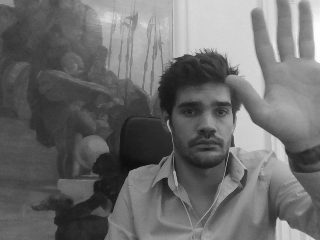

In [11]:
img

## Building the dataset

In [9]:
hand_img = [CameraImage(file_path = file_path,tag = 1,check = True) for file_path in tqdm(hand_files,desc = "Loading hand images")]
not_hand_img = [CameraImage(file_path = file_path,tag = 0,check = True) for file_path in tqdm(not_hand_files,desc = "Loading not hand images")]
all_img = hand_img + not_hand_img
all_img = [img for img in all_img if img.ok]

Loading not hand images: 100%|███████████████| 369/369 [00:04<00:00, 75.09it/s]


In [10]:
images = CameraImages(camera_images=all_img)

In [38]:
images.preprocess()

Preprocessing images: 100%|████████████████| 735/735 [00:00<00:00, 1488.46it/s]


In [24]:
X = images.build_X()

In [25]:
y = images.build_y()

In [26]:
y.shape

(629, 1)

# Train a simple model

In [14]:
# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import model_from_json

## Creating the MLP

In [22]:
model = Sequential()
model.add(Dense(100,input_dim = X.shape[1],activation = "relu"))
# model.add(Dropout(0.25))
model.add(Dense(100,activation = "relu"))
# model.add(Dropout(0.25))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
model.fit(X,y,validation_split=0.3,epochs=10,verbose = 2)

Train on 440 samples, validate on 189 samples
Epoch 1/10
1s - loss: 1.5131 - acc: 0.6023 - val_loss: 2.2446 - val_acc: 0.1746
Epoch 2/10
1s - loss: 0.4961 - acc: 0.7727 - val_loss: 0.9626 - val_acc: 0.5026
Epoch 3/10
1s - loss: 0.2247 - acc: 0.9023 - val_loss: 0.8520 - val_acc: 0.6614
Epoch 4/10
1s - loss: 0.1274 - acc: 0.9523 - val_loss: 1.4515 - val_acc: 0.4444
Epoch 5/10
1s - loss: 0.0815 - acc: 0.9841 - val_loss: 1.0387 - val_acc: 0.5767
Epoch 6/10
1s - loss: 0.0898 - acc: 0.9773 - val_loss: 0.3885 - val_acc: 0.8466
Epoch 7/10
1s - loss: 0.0737 - acc: 0.9841 - val_loss: 0.4925 - val_acc: 0.8201
Epoch 8/10
1s - loss: 0.0544 - acc: 0.9932 - val_loss: 1.5134 - val_acc: 0.4709
Epoch 9/10
1s - loss: 0.0703 - acc: 0.9841 - val_loss: 0.4997 - val_acc: 0.7937
Epoch 10/10
1s - loss: 0.0581 - acc: 0.9864 - val_loss: 0.2011 - val_acc: 0.9259


## Live test

In [45]:
test = CameraImage(capture = True)

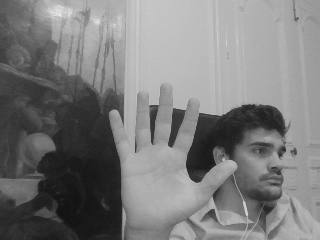

In [46]:
test.preprocess(canny_intensity=30)
test

In [47]:
test.predict(model)

0.00091121963

## Conclusion : 
The model fit very well on the train and dev set, but does not generalize to pictures in a production setting

## Saving the model

In [50]:
model.save("C:/git/computer-vision-control/models/model_mlp.h5")

In [51]:
with open("C:/git/computer-vision-control/models/model.json", "w") as json_file:
    json_file.write(model.to_json())

## Test reloading the model

In [2]:
%%time
from keras.models import model_from_json

Wall time: 0 ns


In [10]:
model = model_from_json(open("C:/git/computer-vision-control/models/model_mlp.json","r").read())
model.load_weights("C:/git/computer-vision-control/models/model_mlp.h5")

# Train a more complex model : CNN

## Building a dataset not flattened

In [39]:
X = images.build_X(flatten=False)
X.shape

(735, 240, 320, 1)

## Creating the model

In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(240,320,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.01)
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
model.fit(X,y,validation_split=0.3,epochs=1,verbose = 1)

Train on 440 samples, validate on 189 samples
Epoch 1/1
440/440 [==============================] - ETA: 297s - loss: 2.6747 - acc: 0.562 - ETA: 234s - loss: 3.3301 - acc: 0.656 - ETA: 202s - loss: 4.2129 - acc: 0.645 - ETA: 178s - loss: 4.5297 - acc: 0.648 - ETA: 156s - loss: 4.9191 - acc: 0.637 - ETA: 137s - loss: 4.6805 - acc: 0.661 - ETA: 117s - loss: 4.7235 - acc: 0.665 - ETA: 98s - loss: 4.4445 - acc: 0.687 - ETA: 80s - loss: 4.6703 - acc: 0.67 - ETA: 62s - loss: 4.5022 - acc: 0.69 - ETA: 45s - loss: 4.2287 - acc: 0.71 - ETA: 28s - loss: 4.2085 - acc: 0.71 - ETA: 12s - loss: 4.3063 - acc: 0.70 - 251s - loss: 4.1801 - acc: 0.7182 - val_loss: 15.9424 - val_acc: 0.0000e+00


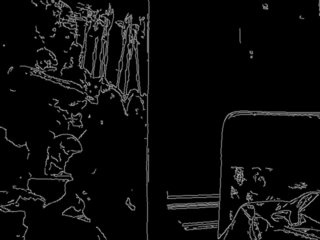

In [31]:
test = CameraImage(capture = True)
test.preprocess()
test

In [32]:
test.predict(model,flatten = False)

0.99779582

# Image Data Generator fit

https://keras.io/preprocessing/image/<br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [13]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [29]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(120,160,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.01)
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,rotation_range = 20)

In [36]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'C:/git/computer-vision-control/images/hand_detection/',  # this is the target directory
        target_size=(120, 160),  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode = "grayscale",
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 736 images belonging to 2 classes.


In [37]:
model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=1)

Epoch 1/1


Exception in thread Thread-50:
Traceback (most recent call last):
  File "C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\lib\site-packages\PIL\ImageFile.py", line 203, in load
    s = read(self.decodermaxblock)
  File "C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\lib\site-packages\PIL\PngImagePlugin.py", line 596, in load_read
    cid, pos, length = self.png.read()
  File "C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\lib\site-packages\PIL\PngImagePlugin.py", line 118, in read
    length = i32(s)
  File "C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\lib\site-packages\PIL\_binary.py", line 57, in i32be
    return unpack(">I", c[o:o+4])[0]
struct.error: unpack requires a bytes object of length 4

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Users\ta

  1/100 [..............................] - ETA: 298s - loss: 0.6954 - acc: 0.5000

StopIteration: 